In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import utils as utils
import scienceplots
from fair import EnergyBalanceModel
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp

In [3]:
ensembles = xr.load_dataarray('../data/contrained-ensemble-ssps.nc')
ensemble_configs = pd.read_csv('../data/constrained-ensemble-configs.nc', index_col=0)
historical_ensemble = ensembles.sel(layer=0, timebounds=slice(1850, 2014), scenario='ssp245').values
historical_tas_fair = torch.from_numpy(historical_ensemble.T).float()

def EBM_to_IR(params):
    ebm = EnergyBalanceModel(ocean_heat_capacity=[params['clim_c1'], params['clim_c2'], params['clim_c3']],
                             ocean_heat_transfer=[params['clim_kappa1'], params['clim_kappa2'], params['clim_kappa3']],
                             deep_ocean_efficacy=params['clim_epsilon'],
                             gamma_autocorrelation=params['clim_gamma'],
                             sigma_xi=params['clim_sigma_xi'],
                             sigma_eta=params['clim_sigma_eta'],
                             forcing_4co2=params['clim_F_4xCO2'],
                             stochastic_run=False,
                             seed=16)
    ebm.impulse_response()
    return ebm.timescales, ebm.response_coefficients

def update_train_mean(fairgpmodel, member_idx, train_tas_fair):
    train_ensemble_member = train_tas_fair[member_idx]
    config_idx = ensembles.config[member_idx].values.item()
    config = ensemble_configs.loc[config_idx]
    d, q = EBM_to_IR(config)
    fairgpmodel.d = torch.from_numpy(d).float()
    fairgpmodel.q = torch.from_numpy(q).float()
    fairgpmodel.register_buffer('train_mean', train_ensemble_member)
    train_targets = fairgpmodel.train_scenarios.tas - train_ensemble_member
    fairgpmodel.register_buffer('train_targets', train_targets)
    fairgpmodel._clear_cache()
    return fairgpmodel

# SSP126

In [4]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = fairgp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp126/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)
fairgpmodel = fairgpmodel.eval()

In [5]:
# Build constrained ensemble for training scenarios centered on NorESM2-LM-tuned FaIR prediction
train_scenarios = train_data.scenarios
train_scenarios_idx = [1, 2, 3]
train_ensembles = ensembles.sel(layer=0, timebounds=slice(2015, None)).isel(scenario=train_scenarios_idx)
train_tas_fair = torch.from_numpy(train_ensembles.values).float().reshape(-1, 1001).T
train_tas_fair = torch.cat([historical_tas_fair, train_tas_fair], dim=-1)
train_tas_fairNorESM = fairgpmodel._compute_mean(train_scenarios).unsqueeze(0)
train_tas_fair = train_tas_fair - train_tas_fair.mean(dim=0) + train_tas_fairNorESM

# Build constrained ensemble for testing scenario centered on NorESM-LM-tuned FaIR prediction
test_scenario = 'ssp126'
test_scenarios = test_data.scenarios
test_tas_fair = torch.from_numpy(ensembles.sel(scenario=test_scenario, layer=0, timebounds=slice(2015, None)).values.T).float()
test_tas_fairNorESM = fairgpmodel._compute_mean(test_scenarios).unsqueeze(0)
test_tas_fair = test_tas_fair - test_tas_fair.mean(dim=0) + test_tas_fairNorESM

In [6]:
posterior_means = []
fairgp_variances = []
OU_variances = []

for idx, (train_member, test_member) in tqdm.notebook.tqdm(enumerate(zip(train_tas_fair, test_tas_fair)), total=1001):
    with torch.no_grad():
        fairgpmodel = update_train_mean(fairgpmodel, idx, train_tas_fair)
        fairgp_test_posterior = fairgpmodel(test_scenarios)
        noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)
        
        posterior_mean = fairgp_test_posterior.mean + test_member
        posterior_means.append(posterior_mean)
        fairgp_variances.append(fairgp_test_posterior.variance)
        OU_variances.append(noisy_fairgp_test_posterior.variance - fairgp_test_posterior.variance)

posteror_means_ssp126 = torch.stack(posterior_means)
fairgp_variances_ssp126 = torch.stack(fairgp_variances)
OU_variances_ssp126 = torch.stack(OU_variances)

  0%|          | 0/1001 [00:00<?, ?it/s]

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [8]:
posterior_means = posteror_means_ssp126[:]
fairgp_variances = fairgp_variances_ssp126[:]
OU_variances = OU_variances_ssp126[:]

posterior_mean = posterior_means.mean(dim=0)
fairgp_var = fairgp_variances.mean(dim=0)
OU_var = OU_variances.mean(dim=0)
ensemble_var = posterior_means.var(dim=0)

fairgp_stddev = torch.sqrt(fairgp_var)
fairgp_lb, fairgp_ub = posterior_mean - 2 * fairgp_stddev, posterior_mean + 2 * fairgp_stddev

OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var)
OU_lb, OU_ub = posterior_mean - 2 * OU_fairgp_stddev, posterior_mean + 2 * OU_fairgp_stddev

ensemble_OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)
ensemble_lb, ensemble_ub = posterior_mean - 2 * ensemble_OU_fairgp_stddev, posterior_mean + 2 * ensemble_OU_fairgp_stddev

In [9]:
total_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)

fairgp_frac = 100 * fairgp_stddev / total_stddev
fairgp_frac = fairgp_frac.numpy()

OU_frac = 100 * (OU_fairgp_stddev - fairgp_stddev) / total_stddev
OU_frac = OU_frac.numpy()

ensemble_frac = 100 * (total_stddev - OU_fairgp_stddev) / total_stddev
ensemble_frac = ensemble_frac.numpy()

In [10]:
choice = 'Spectral'
cmap = matplotlib.cm.get_cmap(choice)
cwheel = [cmap(0.4), cmap(0.25), cmap(0.8)]

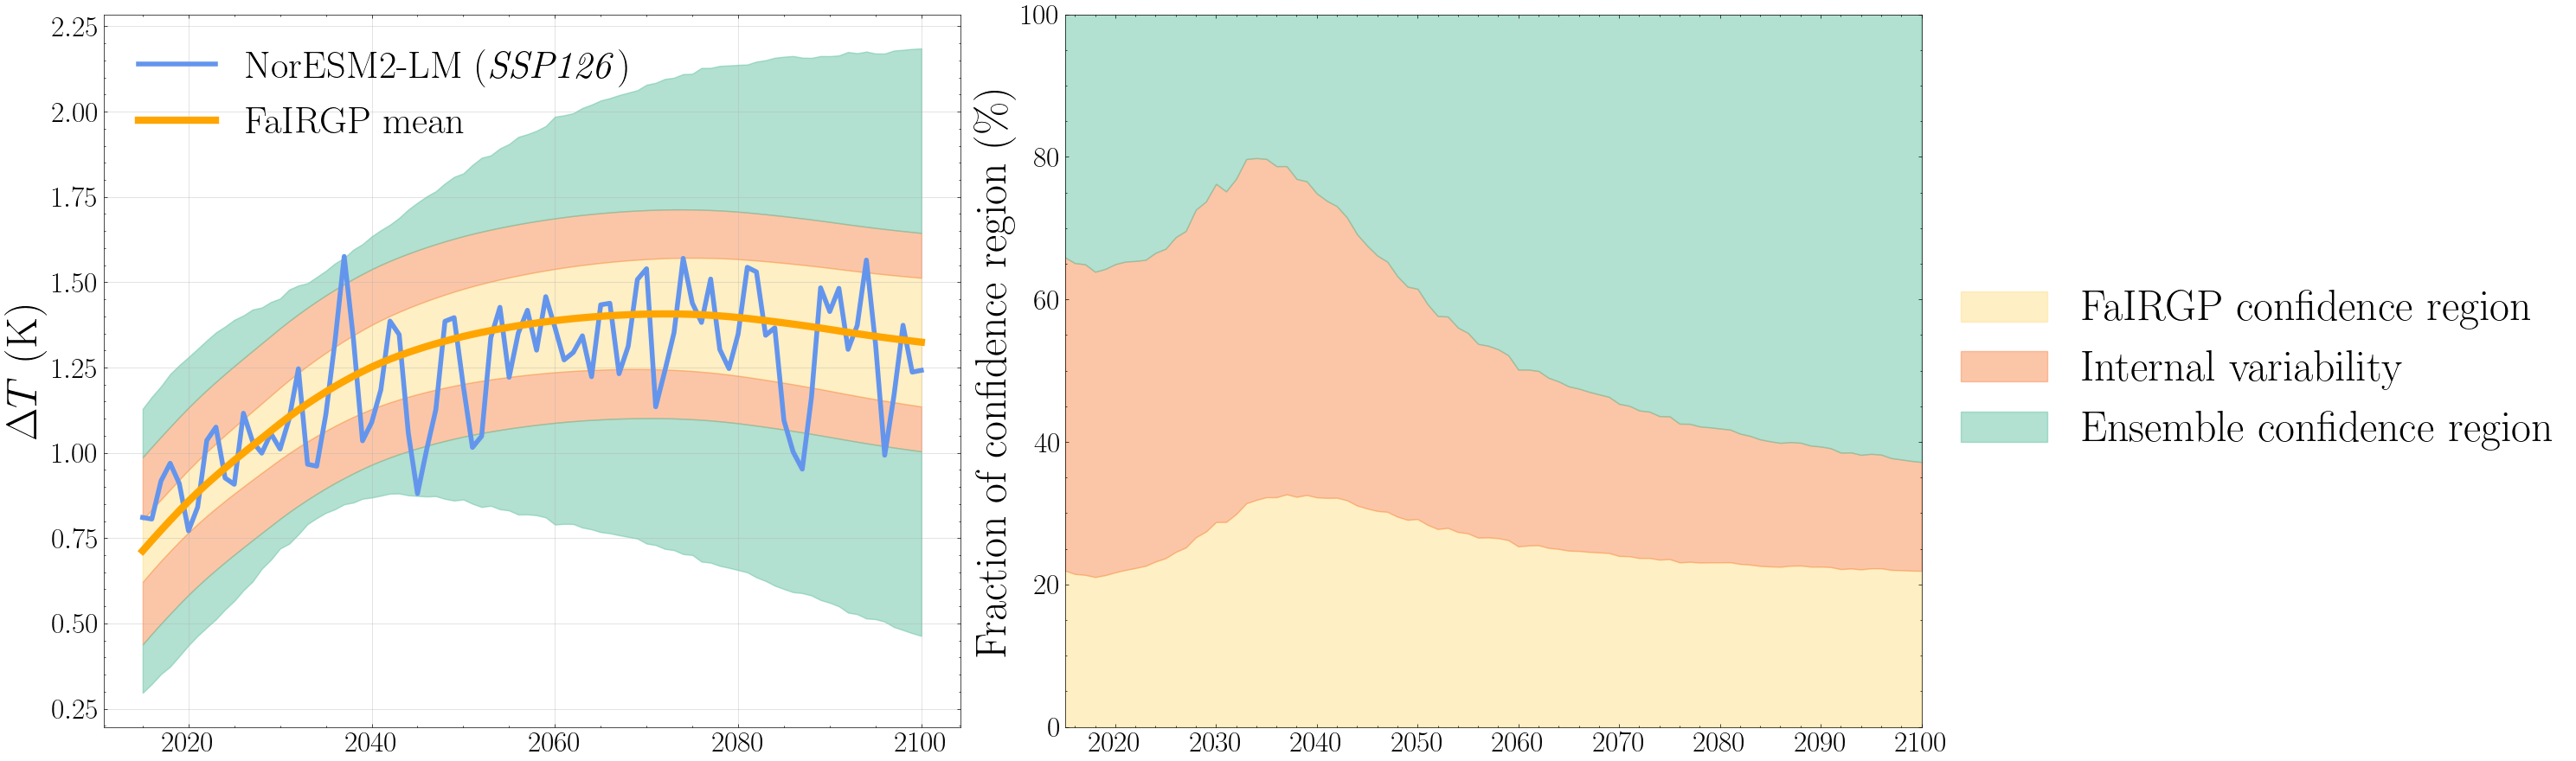

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(28, 9))

test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

ymax = max(ensemble_ub) + 0.1
ymin = min(ensemble_lb).item() - 0.1


ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label=r'NorESM2-LM (\textit{SSP126})')
ax[0].plot(test_times, posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0].fill_between(test_times, fairgp_lb, fairgp_ub, alpha=0.5, color=cwheel[0])
ax[0].fill_between(test_times, fairgp_ub, OU_ub, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, OU_lb, fairgp_lb, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, ensemble_lb, OU_lb, alpha=0.5, color=cwheel[2])
ax[0].fill_between(test_times, OU_ub, ensemble_ub, alpha=0.5, color=cwheel[2])
ax[0].tick_params(labelsize=24)
ax[0].grid(alpha=0.5)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel(r'$\Delta T$ (K)', fontsize=36)
# ax[0].set_title(r'Contribution of different sources of uncertainty to FaIRGP posterior', fontsize=28)

legend = ax[0].legend(loc='upper left', fontsize=32)
# legend.legendHandles[2].set_alpha(0.6)
# legend.legendHandles[3].set_alpha(0.4)


ax[1].fill_between(test_times, np.zeros_like(ensemble_frac), fairgp_frac, label='FaIRGP confidence region', color=cwheel[0], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac, fairgp_frac + OU_frac, label='Internal variability', color=cwheel[1], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac + OU_frac, ensemble_frac + fairgp_frac + OU_frac, label='Ensemble confidence region', color=cwheel[2], alpha=0.5)
ax[1].set_ylabel("Fraction of confidence region (\%)", fontsize=36)
ax[1].tick_params(labelsize=24)
ax[1].set_ylim(0, 100)
ax[1].set_xlim(2015, 2100)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=36)

plt.tight_layout()
# plt.savefig('./figures/SSP126-with-constrained-ensemble.jpg', dpi=200)
plt.show()

# SSP245

In [123]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = fairgp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)
fairgpmodel = fairgpmodel.eval()

In [124]:
# Build constrained ensemble for training scenarios centered on NorESM2-LM-tuned FaIR prediction
train_scenarios = train_data.scenarios
train_scenarios_idx = [0, 2, 3]
train_ensembles = ensembles.sel(layer=0, timebounds=slice(2015, None)).isel(scenario=train_scenarios_idx)
train_tas_fair = torch.from_numpy(train_ensembles.values).float().reshape(-1, 1001).T
train_tas_fair = torch.cat([historical_tas_fair, train_tas_fair], dim=-1)
train_tas_fairNorESM = fairgpmodel._compute_mean(train_scenarios).unsqueeze(0)
train_tas_fair = train_tas_fair - train_tas_fair.mean(dim=0) + train_tas_fairNorESM

# Build constrained ensemble for testing scenario centered on NorESM-LM-tuned FaIR prediction
test_scenario = 'ssp245'
test_scenarios = test_data.scenarios
test_tas_fair = torch.from_numpy(ensembles.sel(scenario=test_scenario, layer=0, timebounds=slice(2015, None)).values.T).float()
test_tas_fairNorESM = fairgpmodel._compute_mean(test_scenarios).unsqueeze(0)
test_tas_fair = test_tas_fair - test_tas_fair.mean(dim=0) + test_tas_fairNorESM

In [128]:
posterior_means = []
fairgp_variances = []
OU_variances = []

for idx, (train_member, test_member) in tqdm.notebook.tqdm(enumerate(zip(train_tas_fair, test_tas_fair)), total=1001):
    with torch.no_grad():
        fairgpmodel = update_train_mean(fairgpmodel, idx, train_tas_fair)
        fairgp_test_posterior = fairgpmodel(test_scenarios)
        noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)
        
        posterior_mean = fairgp_test_posterior.mean + test_member
        posterior_means.append(posterior_mean)
        fairgp_variances.append(fairgp_test_posterior.variance)
        OU_variances.append(noisy_fairgp_test_posterior.variance - fairgp_test_posterior.variance)

posteror_means_ssp245 = torch.stack(posterior_means)
fairgp_variances_ssp245 = torch.stack(fairgp_variances)
OU_variances_ssp245 = torch.stack(OU_variances)

  0%|          | 0/1001 [00:00<?, ?it/s]

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [153]:
posterior_means = posteror_means_ssp245[:]
fairgp_variances = fairgp_variances_ssp245[:]
OU_variances = OU_variances_ssp245[:]

posterior_mean = posterior_means.mean(dim=0)
fairgp_var = fairgp_variances.mean(dim=0)
OU_var = OU_variances.mean(dim=0)
ensemble_var = posterior_means.var(dim=0)

fairgp_stddev = torch.sqrt(fairgp_var)
fairgp_lb, fairgp_ub = posterior_mean - 2 * fairgp_stddev, posterior_mean + 2 * fairgp_stddev

OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var)
OU_lb, OU_ub = posterior_mean - 2 * OU_fairgp_stddev, posterior_mean + 2 * OU_fairgp_stddev

ensemble_OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)
ensemble_lb, ensemble_ub = posterior_mean - 2 * ensemble_OU_fairgp_stddev, posterior_mean + 2 * ensemble_OU_fairgp_stddev

In [149]:
total_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)

fairgp_frac = 100 * fairgp_stddev / total_stddev
fairgp_frac = fairgp_frac.numpy()

OU_frac = 100 * (OU_fairgp_stddev - fairgp_stddev) / total_stddev
OU_frac = OU_frac.numpy()

ensemble_frac = 100 * (total_stddev - OU_fairgp_stddev) / total_stddev
ensemble_frac = ensemble_frac.numpy()

In [150]:
choice = 'Spectral'
cmap = matplotlib.cm.get_cmap(choice)
cwheel = [cmap(0.4), cmap(0.25), cmap(0.8)]

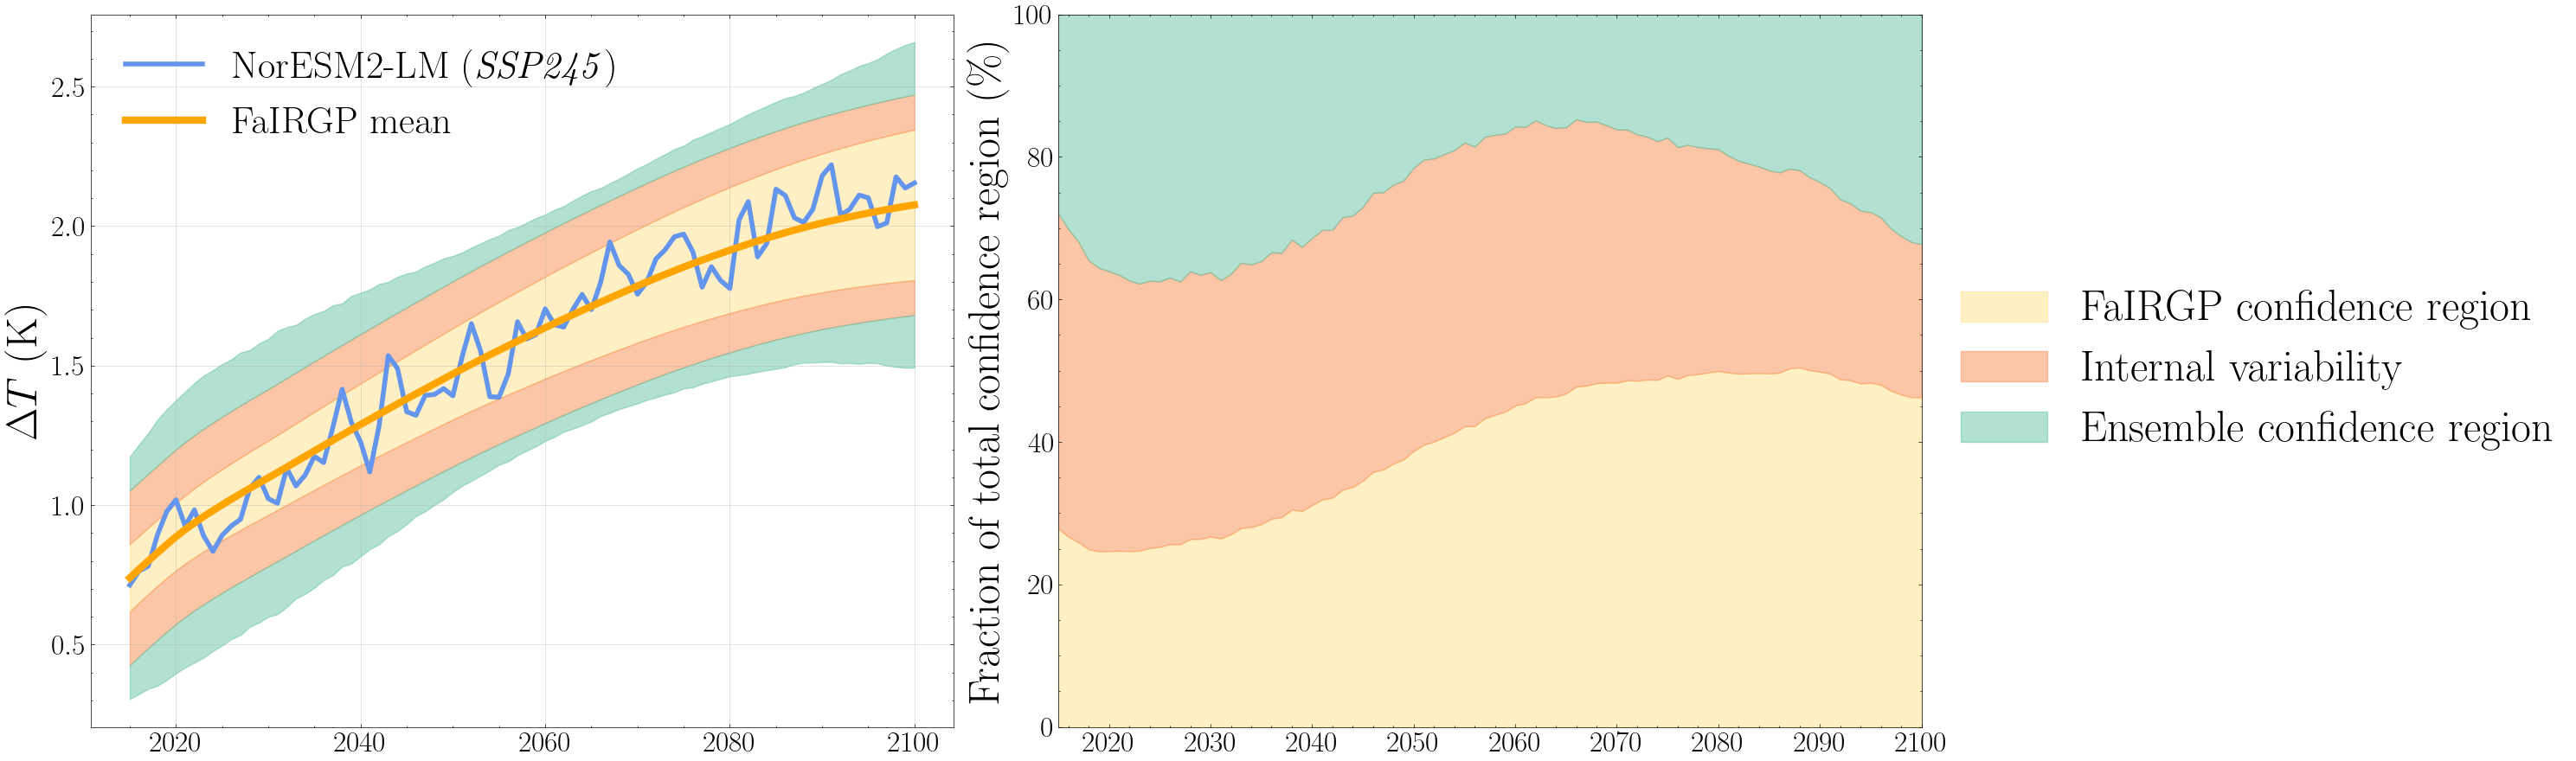

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(28, 9))

test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

ymax = max(ensemble_ub) + 0.1
ymin = min(ensemble_lb).item() - 0.1


ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label=r'NorESM2-LM (\textit{SSP245})')
ax[0].plot(test_times, posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0].fill_between(test_times, fairgp_lb, fairgp_ub, alpha=0.5, color=cwheel[0])
ax[0].fill_between(test_times, fairgp_ub, OU_ub, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, OU_lb, fairgp_lb, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, ensemble_lb, OU_lb, alpha=0.5, color=cwheel[2])
ax[0].fill_between(test_times, OU_ub, ensemble_ub, alpha=0.5, color=cwheel[2])
ax[0].tick_params(labelsize=24)
ax[0].grid(alpha=0.5)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel(r'$\Delta T$ (K)', fontsize=36)
# ax[0].set_title(r'Contribution of different sources of uncertainty to FaIRGP posterior', fontsize=28)

legend = ax[0].legend(loc='upper left', fontsize=32)
# legend.legendHandles[2].set_alpha(0.6)
# legend.legendHandles[3].set_alpha(0.4)


ax[1].fill_between(test_times, np.zeros_like(ensemble_frac), fairgp_frac, label='FaIRGP confidence region', color=cwheel[0], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac, fairgp_frac + OU_frac, label='Internal variability', color=cwheel[1], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac + OU_frac, ensemble_frac + fairgp_frac + OU_frac, label='Ensemble confidence region', color=cwheel[2], alpha=0.5)
ax[1].set_ylabel("Fraction of total confidence region (\%)", fontsize=36)
ax[1].tick_params(labelsize=24)
ax[1].set_ylim(0, 100)
ax[1].set_xlim(2015, 2100)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=36)

plt.tight_layout()
plt.savefig('./figures/SSP245-with-constrained-ensemble.jpg', dpi=200)
plt.show()

# SSP370

In [163]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp370']}}
test_data = fairgp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp370/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)
fairgpmodel = fairgpmodel.eval()

In [164]:
# Build constrained ensemble for training scenarios centered on NorESM2-LM-tuned FaIR prediction
train_scenarios = train_data.scenarios
train_scenarios_idx = [0, 1, 3]
train_ensembles = ensembles.sel(layer=0, timebounds=slice(2015, None)).isel(scenario=train_scenarios_idx)
train_tas_fair = torch.from_numpy(train_ensembles.values).float().reshape(-1, 1001).T
train_tas_fair = torch.cat([historical_tas_fair, train_tas_fair], dim=-1)
train_tas_fairNorESM = fairgpmodel._compute_mean(train_scenarios).unsqueeze(0)
train_tas_fair = train_tas_fair - train_tas_fair.mean(dim=0) + train_tas_fairNorESM

# Build constrained ensemble for testing scenario centered on NorESM-LM-tuned FaIR prediction
test_scenario = 'ssp370'
test_scenarios = test_data.scenarios
test_tas_fair = torch.from_numpy(ensembles.sel(scenario=test_scenario, layer=0, timebounds=slice(2015, None)).values.T).float()
test_tas_fairNorESM = fairgpmodel._compute_mean(test_scenarios).unsqueeze(0)
test_tas_fair = test_tas_fair - test_tas_fair.mean(dim=0) + test_tas_fairNorESM

In [165]:
posterior_means = []
fairgp_variances = []
OU_variances = []

for idx, (train_member, test_member) in tqdm.notebook.tqdm(enumerate(zip(train_tas_fair, test_tas_fair)), total=1001):
    with torch.no_grad():
        fairgpmodel = update_train_mean(fairgpmodel, idx, train_tas_fair)
        fairgp_test_posterior = fairgpmodel(test_scenarios)
        noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)
        
        posterior_mean = fairgp_test_posterior.mean + test_member
        posterior_means.append(posterior_mean)
        fairgp_variances.append(fairgp_test_posterior.variance)
        OU_variances.append(noisy_fairgp_test_posterior.variance - fairgp_test_posterior.variance)

posteror_means_ssp370 = torch.stack(posterior_means)
fairgp_variances_ssp370 = torch.stack(fairgp_variances)
OU_variances_ssp370 = torch.stack(OU_variances)

  0%|          | 0/1001 [00:00<?, ?it/s]

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [166]:
posterior_means = posteror_means_ssp370[:]
fairgp_variances = fairgp_variances_ssp370[:]
OU_variances = OU_variances_ssp370[:]

posterior_mean = posterior_means.mean(dim=0)
fairgp_var = fairgp_variances.mean(dim=0)
OU_var = OU_variances.mean(dim=0)
ensemble_var = posterior_means.var(dim=0)

fairgp_stddev = torch.sqrt(fairgp_var)
fairgp_lb, fairgp_ub = posterior_mean - 2 * fairgp_stddev, posterior_mean + 2 * fairgp_stddev

OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var)
OU_lb, OU_ub = posterior_mean - 2 * OU_fairgp_stddev, posterior_mean + 2 * OU_fairgp_stddev

ensemble_OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)
ensemble_lb, ensemble_ub = posterior_mean - 2 * ensemble_OU_fairgp_stddev, posterior_mean + 2 * ensemble_OU_fairgp_stddev

In [167]:
total_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)

fairgp_frac = 100 * fairgp_stddev / total_stddev
fairgp_frac = fairgp_frac.numpy()

OU_frac = 100 * (OU_fairgp_stddev - fairgp_stddev) / total_stddev
OU_frac = OU_frac.numpy()

ensemble_frac = 100 * (total_stddev - OU_fairgp_stddev) / total_stddev
ensemble_frac = ensemble_frac.numpy()

In [168]:
choice = 'Spectral'
cmap = matplotlib.cm.get_cmap(choice)
cwheel = [cmap(0.4), cmap(0.25), cmap(0.8)]

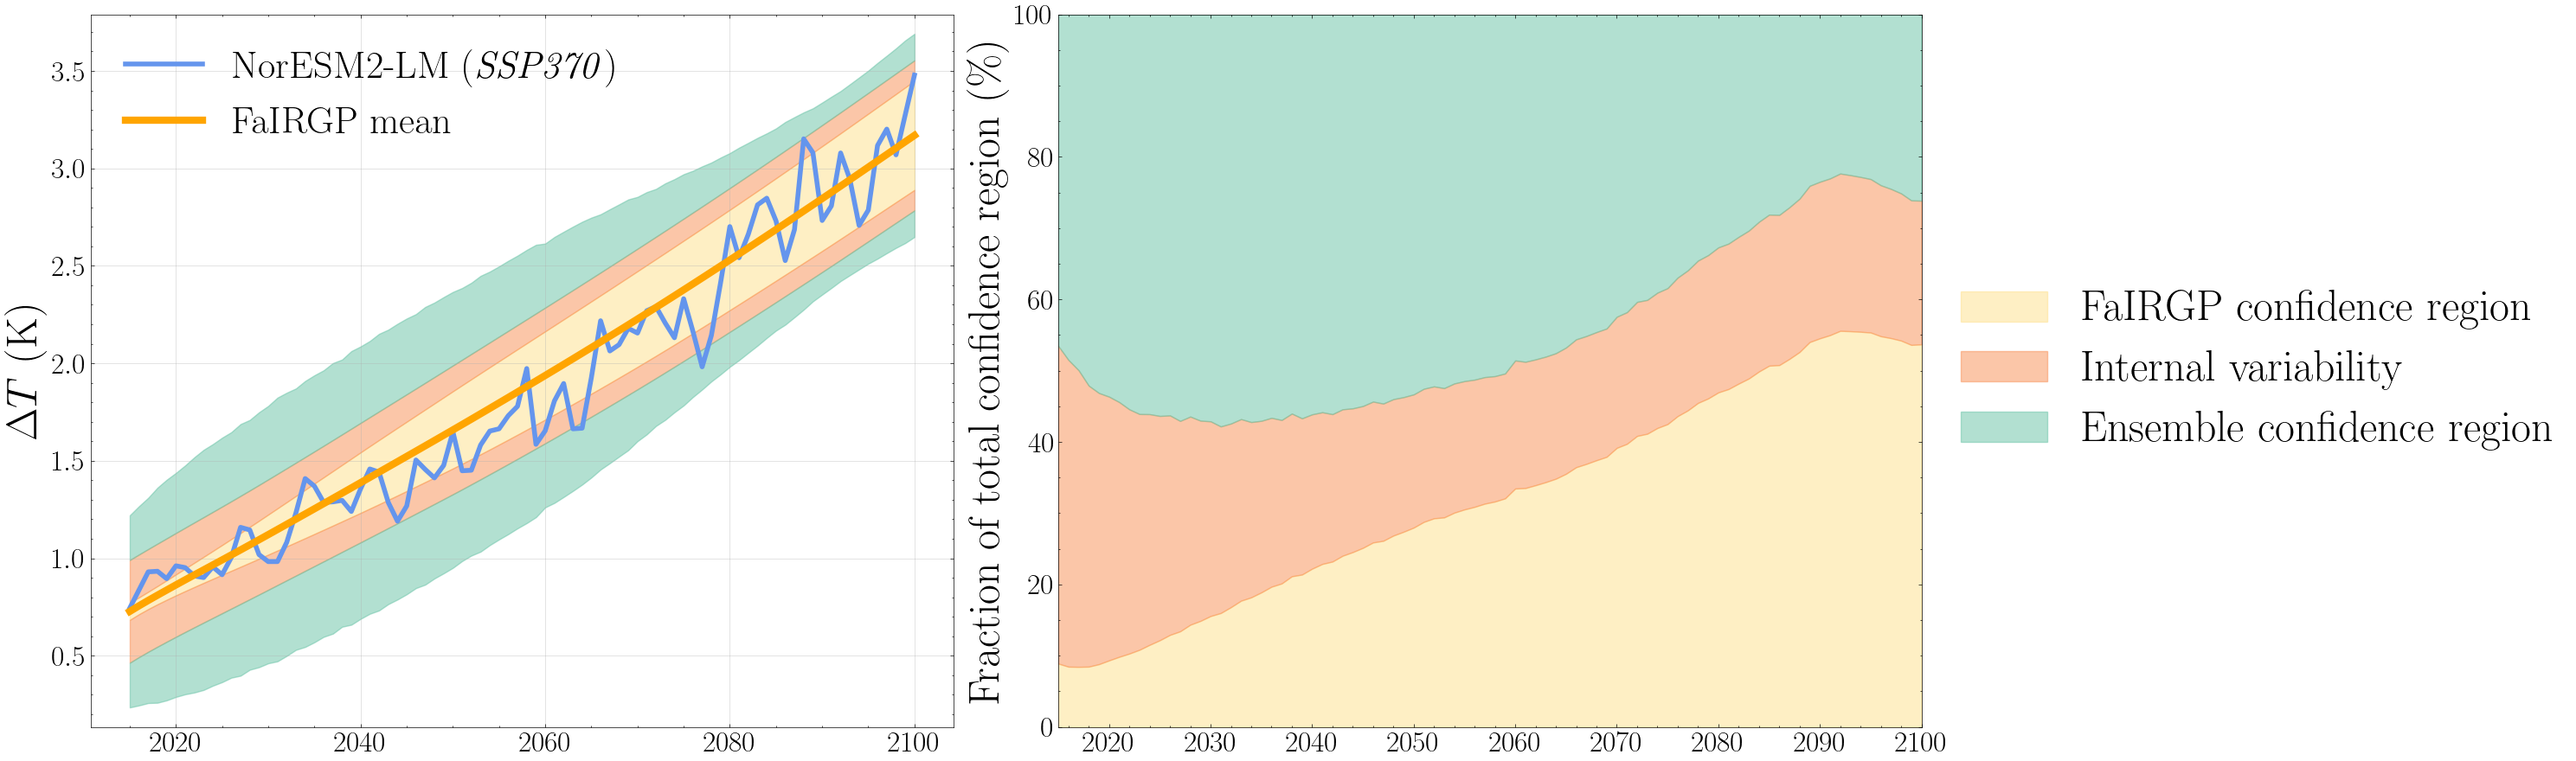

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(28, 9))

test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

ymax = max(ensemble_ub) + 0.1
ymin = min(ensemble_lb).item() - 0.1


ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label=r'NorESM2-LM (\textit{SSP370})')
ax[0].plot(test_times, posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0].fill_between(test_times, fairgp_lb, fairgp_ub, alpha=0.5, color=cwheel[0])
ax[0].fill_between(test_times, fairgp_ub, OU_ub, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, OU_lb, fairgp_lb, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, ensemble_lb, OU_lb, alpha=0.5, color=cwheel[2])
ax[0].fill_between(test_times, OU_ub, ensemble_ub, alpha=0.5, color=cwheel[2])
ax[0].tick_params(labelsize=24)
ax[0].grid(alpha=0.5)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel(r'$\Delta T$ (K)', fontsize=36)
# ax[0].set_title(r'Contribution of different sources of uncertainty to FaIRGP posterior', fontsize=28)

legend = ax[0].legend(loc='upper left', fontsize=32)
# legend.legendHandles[2].set_alpha(0.6)
# legend.legendHandles[3].set_alpha(0.4)


ax[1].fill_between(test_times, np.zeros_like(ensemble_frac), fairgp_frac, label='FaIRGP confidence region', color=cwheel[0], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac, fairgp_frac + OU_frac, label='Internal variability', color=cwheel[1], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac + OU_frac, ensemble_frac + fairgp_frac + OU_frac, label='Ensemble confidence region', color=cwheel[2], alpha=0.5)
ax[1].set_ylabel("Fraction of total confidence region (\%)", fontsize=36)
ax[1].tick_params(labelsize=24)
ax[1].set_ylim(0, 100)
ax[1].set_xlim(2015, 2100)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=36)

plt.tight_layout()
# plt.savefig('./figures/SSP370-with-constrained-ensemble.jpg', dpi=200)
plt.show()

# SSP585

In [171]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = fairgp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)
fairgpmodel = fairgpmodel.eval()

In [172]:
# Build constrained ensemble for training scenarios centered on NorESM2-LM-tuned FaIR prediction
train_scenarios = train_data.scenarios
train_scenarios_idx = [0, 1, 2]
train_ensembles = ensembles.sel(layer=0, timebounds=slice(2015, None)).isel(scenario=train_scenarios_idx)
train_tas_fair = torch.from_numpy(train_ensembles.values).float().reshape(-1, 1001).T
train_tas_fair = torch.cat([historical_tas_fair, train_tas_fair], dim=-1)
train_tas_fairNorESM = fairgpmodel._compute_mean(train_scenarios).unsqueeze(0)
train_tas_fair = train_tas_fair - train_tas_fair.mean(dim=0) + train_tas_fairNorESM

# Build constrained ensemble for testing scenario centered on NorESM-LM-tuned FaIR prediction
test_scenario = 'ssp585'
test_scenarios = test_data.scenarios
test_tas_fair = torch.from_numpy(ensembles.sel(scenario=test_scenario, layer=0, timebounds=slice(2015, None)).values.T).float()
test_tas_fairNorESM = fairgpmodel._compute_mean(test_scenarios).unsqueeze(0)
test_tas_fair = test_tas_fair - test_tas_fair.mean(dim=0) + test_tas_fairNorESM

In [173]:
posterior_means = []
fairgp_variances = []
OU_variances = []

for idx, (train_member, test_member) in tqdm.notebook.tqdm(enumerate(zip(train_tas_fair, test_tas_fair)), total=1001):
    with torch.no_grad():
        fairgpmodel = update_train_mean(fairgpmodel, idx, train_tas_fair)
        fairgp_test_posterior = fairgpmodel(test_scenarios)
        noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)
        
        posterior_mean = fairgp_test_posterior.mean + test_member
        posterior_means.append(posterior_mean)
        fairgp_variances.append(fairgp_test_posterior.variance)
        OU_variances.append(noisy_fairgp_test_posterior.variance - fairgp_test_posterior.variance)

posterior_means_ssp585 = torch.stack(posterior_means)
fairgp_variances_ssp585 = torch.stack(fairgp_variances)
OU_variances_ssp585 = torch.stack(OU_variances)

  0%|          | 0/1001 [00:00<?, ?it/s]

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [174]:
posterior_means = posterior_means_ssp585[:]
fairgp_variances = fairgp_variances_ssp585[:]
OU_variances = OU_variances_ssp585[:]

posterior_mean = posterior_means.mean(dim=0)
fairgp_var = fairgp_variances.mean(dim=0)
OU_var = OU_variances.mean(dim=0)
ensemble_var = posterior_means.var(dim=0)

fairgp_stddev = torch.sqrt(fairgp_var)
fairgp_lb, fairgp_ub = posterior_mean - 2 * fairgp_stddev, posterior_mean + 2 * fairgp_stddev

OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var)
OU_lb, OU_ub = posterior_mean - 2 * OU_fairgp_stddev, posterior_mean + 2 * OU_fairgp_stddev

ensemble_OU_fairgp_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)
ensemble_lb, ensemble_ub = posterior_mean - 2 * ensemble_OU_fairgp_stddev, posterior_mean + 2 * ensemble_OU_fairgp_stddev

In [175]:
total_stddev = torch.sqrt(fairgp_var + OU_var + ensemble_var)

fairgp_frac = 100 * fairgp_stddev / total_stddev
fairgp_frac = fairgp_frac.numpy()

OU_frac = 100 * (OU_fairgp_stddev - fairgp_stddev) / total_stddev
OU_frac = OU_frac.numpy()

ensemble_frac = 100 * (total_stddev - OU_fairgp_stddev) / total_stddev
ensemble_frac = ensemble_frac.numpy()

In [176]:
choice = 'Spectral'
cmap = matplotlib.cm.get_cmap(choice)
cwheel = [cmap(0.4), cmap(0.25), cmap(0.8)]

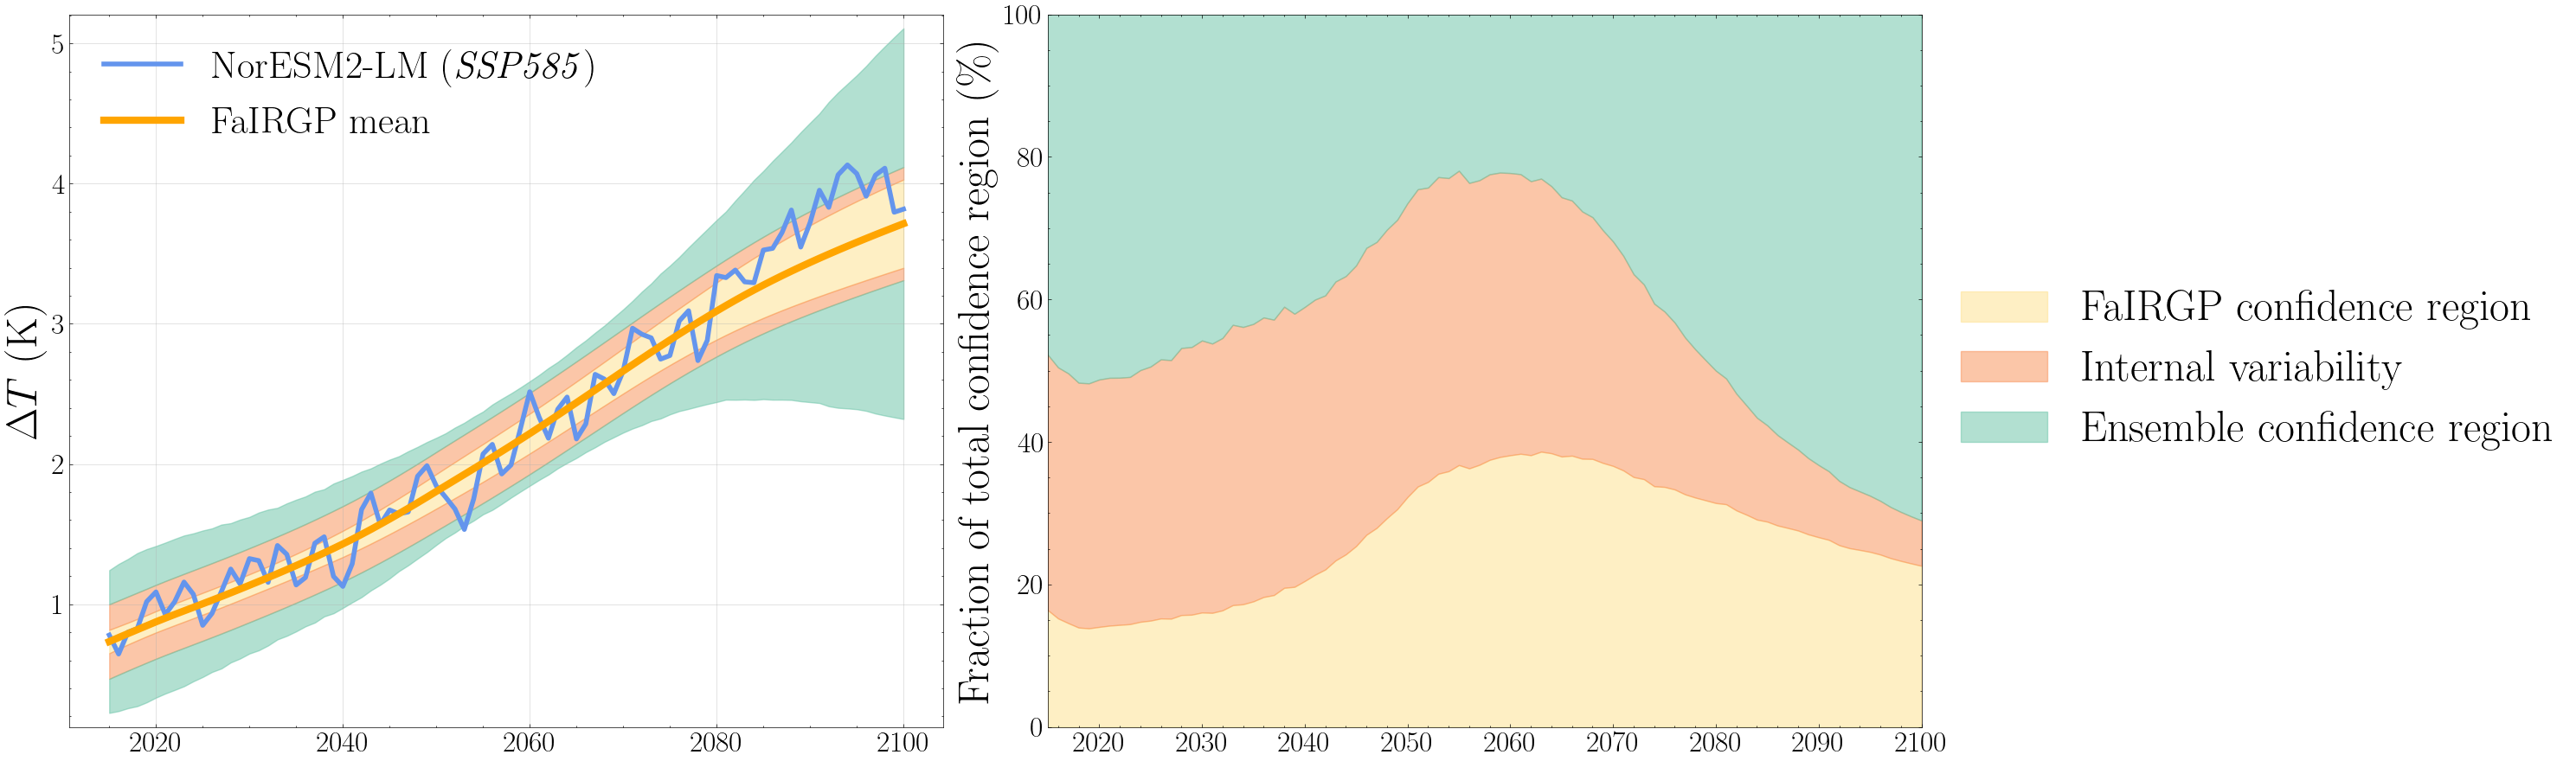

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(28, 9))

test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

ymax = max(ensemble_ub) + 0.1
ymin = min(ensemble_lb).item() - 0.1


ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label=r'NorESM2-LM (\textit{SSP585})')
ax[0].plot(test_times, posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0].fill_between(test_times, fairgp_lb, fairgp_ub, alpha=0.5, color=cwheel[0])
ax[0].fill_between(test_times, fairgp_ub, OU_ub, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, OU_lb, fairgp_lb, alpha=0.5, color=cwheel[1])
ax[0].fill_between(test_times, ensemble_lb, OU_lb, alpha=0.5, color=cwheel[2])
ax[0].fill_between(test_times, OU_ub, ensemble_ub, alpha=0.5, color=cwheel[2])
ax[0].tick_params(labelsize=24)
ax[0].grid(alpha=0.5)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel(r'$\Delta T$ (K)', fontsize=36)

legend = ax[0].legend(loc='upper left', fontsize=32)


ax[1].fill_between(test_times, np.zeros_like(ensemble_frac), fairgp_frac, label='FaIRGP confidence region', color=cwheel[0], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac, fairgp_frac + OU_frac, label='Internal variability', color=cwheel[1], alpha=0.5)
ax[1].fill_between(test_times, fairgp_frac + OU_frac, ensemble_frac + fairgp_frac + OU_frac, label='Ensemble confidence region', color=cwheel[2], alpha=0.5)
ax[1].set_ylabel("Fraction of total confidence region (\%)", fontsize=36)
ax[1].tick_params(labelsize=24)
ax[1].set_ylim(0, 100)
ax[1].set_xlim(2015, 2100)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=36)

plt.tight_layout()
plt.savefig('./figures/SSP585-with-constrained-ensemble.jpg', dpi=200)
plt.show()